<a href="https://colab.research.google.com/github/Wobins/word2vec-pytorch/blob/main/word2vec_skip_gram_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

CONTEXT_SIZE = 2 # fenetre de 2 mots avant et apres (contexte)
EMBEDDING_DIM = 10 # Nombre de poids de notre couche Embedding

In [ ]:
# @title Corpus

# Source : J. Maitre, K. Bouchard and S. Gaboury, "Fall Detection With UWB Radars and CNN-LSTM Architecture,"
# in IEEE Journal of Biomedical and Health Informatics, vol. 25, no. 4, pp. 1273-1283, April 2021, doi: 10.1109/JBHI.2020.3027967.
corpus = """Abstract—Fall detection is a major challenge for researchers.
Indeed, a fall can cause injuries such as femoral neck fracture, brain hemorrhage, or skin burns, leading to
significant pain. However, in some cases, trauma caused by an undetected fall can get worse with the time and conducts
to painful end of life or even death. One solution is to detect falls efficiently to alert somebody (e.g., nurses) as
quickly as possible. To respond to this need, we propose to detect falls in a real apartment of 40 square meters by
exploiting three ultra-wideband radars and a deep neural network model. The deep neural network is composed of
a convolutional neural network stacked with a long-short term memory network and a fully connected neural network
to identify falls. In other words, the problem addressed in this paper is a binary classification attempting to differentiate fall and
non-fall events. As it can be noticed in real cases, the falls can have different forms. Hence, the data
to train and test the classification model have been generated with falls
(four types) simulated by 10 participants
in three locations in the apartment. Finally, the train and
test stages have been achieved according to three strategies, including the
leave-one-subject-out method. This latter method allows for obtaining the
performances of the
proposed system in a generalization context. The results are very promising
since we reach almost 90% of
accuracy."""

In [ ]:
# @title Preparation du vocabulaire
test_sentence = corpus.split()
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

# 3 premiers elements de la fenetre et vocabulaire resultant du corpus
ngrams[:3], word_to_ix

([(['detection', 'Abstract—Fall'], 'is'),
  (['is', 'detection'], 'a'),
  (['a', 'is'], 'major')],
 {'efficiently': 0,
  'However,': 1,
  'have': 2,
  'or': 3,
  'this': 4,
  '40': 5,
  'get': 6,
  'exploiting': 7,
  'can': 8,
  'quickly': 9,
  'a': 10,
  'Hence,': 11,
  'and': 12,
  'possible.': 13,
  'in': 14,
  'The': 15,
  'classification': 16,
  'detection': 17,
  'meters': 18,
  'according': 19,
  'strategies,': 20,
  'binary': 21,
  'burns,': 22,
  'pain.': 23,
  'cases,': 24,
  'addressed': 25,
  'for': 26,
  'forms.': 27,
  'In': 28,
  'challenge': 29,
  'real': 30,
  'leave-one-subject-out': 31,
  'neck': 32,
  'painful': 33,
  'been': 34,
  'very': 35,
  'other': 36,
  'fully': 37,
  '(e.g.,': 38,
  'term': 39,
  'cause': 40,
  'hemorrhage,': 41,
  'latter': 42,
  'method': 43,
  '(four': 44,
  'deep': 45,
  'accuracy.': 46,
  'including': 47,
  'radars': 48,
  '10': 49,
  'Abstract—Fall': 50,
  'an': 51,
  'test': 52,
  'allows': 53,
  'somebody': 54,
  'such': 55,
  'squar

In [ ]:
# @title Definition du modele

class SkipGram_Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipGram_Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [ ]:
# @title Entrainement du modele

losses = []
loss_function = nn.NLLLoss()
model = SkipGram_Word2Vec(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:
        # Preparation des entrees
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        # Mise du gradient a 0
        model.zero_grad()
        # Passe en avant
        log_probs = model(context_idxs)
        # Valeur de la fonction de perte
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        # Passe en arriere et mise a jour du gradient
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # Valeurs de la fonction de perte qui decroit

[1158.946831703186, 1151.269253730774, 1143.7148065567017, 1136.2730069160461, 1128.939250946045, 1121.7026824951172, 1114.5578451156616, 1107.4941685199738, 1100.5121068954468, 1093.60684800148]


In [ ]:
# @title Prediction

# version latente du contexte issu du mot "network"
model.embeddings.weight[word_to_ix["network"]]

tensor([ 0.4987,  0.8098,  1.3621, -0.4705, -2.9048, -0.8704,  1.4952, -2.4357,
        -0.8075,  0.2613], grad_fn=<SelectBackward0>)

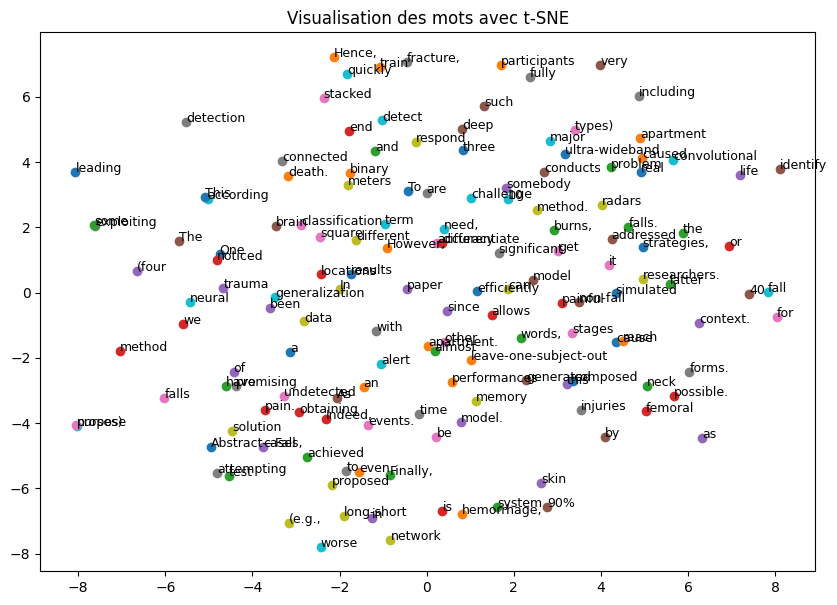

In [ ]:
# @title Visualisation

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. Récupérer tous les embeddings
embeddings = model.embeddings.weight.detach().numpy()  # Shape (vocab_size, embedding_dim)

# 2. Appliquer t-SNE pour réduire à 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Ajuste perplexity selon le vocab
embeddings_2d = tsne.fit_transform(embeddings)

# 3. Visualisation avec Matplotlib
plt.figure(figsize=(10, 7))

# Affichage des points et annotations
for word, idx in word_to_ix.items():
    x, y = embeddings_2d[idx]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)

plt.title("Visualisation des mots avec t-SNE")
plt.show()


In [ ]:
# @title Similarite Cosinus

from sklearn.metrics.pairwise import cosine_similarity

# Récupérer l'embedding d'un mot spécifique
word = "fall"
word_vec = embeddings[word_to_ix[word]].reshape(1, -1)

# Calculer la similarité cosinus avec tous les autres mots
similarities = cosine_similarity(word_vec, embeddings).flatten()

# Trier par similarité décroissante
similar_words = sorted(zip(word_to_ix.keys(), similarities), key=lambda x: x[1], reverse=True)

# Afficher les mots les plus proches
print("Mots les plus proches de '{}':".format(word))
for w, score in similar_words[:5]:  # Top 5 mots similaires
    print(f"{w}: {score:.4f}")


Mots les plus proches de 'fall':
fall: 1.0000
40: 0.8067
for: 0.6837
significant: 0.6196
context.: 0.5982
